In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os
import random

# Sous Windows, chemin jusqu'au fichier à telecharger 
OPENSLIDE_PATH = r'C:\Users\lasse\Documents\INSA\Projet_5BIM\openslide-bin-4.0.0.6-windows-x64\openslide-bin-4.0.0.6-windows-x64\bin'

if hasattr(os, 'add_dll_directory'):
    # Windows
    with os.add_dll_directory(OPENSLIDE_PATH):
        import openslide
else:
    import openslide

from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics       import silhouette_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from pyod.models.auto_encoder import AutoEncoder
from sklearn import svm


c:\Users\lasse\anaconda3\envs\conch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Importation des vecteurs encodés

In [2]:
# Chemin vers le dossier ou sont stockés les vecteurs encodés pour toutes les lames
path = 'Embeddings/Batch2/'
all_embeds=list(glob.iglob(path+'*.csv'))

# Nombre de lames que l'on souhaite importer
nb_wsi=60

all_df=[]
all_wsi=[]
all_bap1_mutation=[]

meta_slide = pd.DataFrame(columns=['Slide','BAP1_mutation'])

for i in range(nb_wsi):
    df = pd.read_csv(all_embeds[i], header=0, index_col=0)
    all_wsi.append(df.iloc[0,0])
    all_bap1_mutation.append(df.iloc[0,1])
    all_df.append(df)

all=pd.concat(all_df)
d = {'Slide': all_wsi, 'BAP1_mutation': all_bap1_mutation}
meta_slide = pd.DataFrame(data=d)

In [3]:
print('Nombre de tuiles total: ', all.shape[0])
print('BAP1 exprimé: ')
print('Nombre de lames: ', meta_slide.loc[meta_slide["BAP1_mutation"]==4].shape[0])
print('Nombre de tuiles: ', all.loc[all["BAP1_mutation"]==4].shape[0])
print('BAP1 non exprimé: ')
print('Nombre de lames: ', meta_slide.loc[meta_slide["BAP1_mutation"]==0].shape[0])
print('Nombre de tuiles: ', all.loc[all["BAP1_mutation"]==0].shape[0])

Nombre de tuiles total:  87096
BAP1 exprimé: 
Nombre de lames:  26
Nombre de tuiles:  35670
BAP1 non exprimé: 
Nombre de lames:  34
Nombre de tuiles:  51426


## Visualisation des vecteurs

In [ ]:
reducer = UMAP(n_neighbors=30, min_dist=0.5, random_state=42)
X_red=reducer.fit_transform(all.iloc[:,4:516])
X_red_df=pd.DataFrame(X_red, index = all.index)
all_red = pd.concat([all.iloc[:,0:4], X_red_df], axis = 1)

In [ ]:
# Visualisation en fonction des lames 

palette = sns.color_palette("Spectral", n_colors=60)

sns.scatterplot(
   x=0,
   y=1,
   data=all_red,
   hue="Slide",
   palette = palette
)

plt.legend(ncol=6, bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
# Visualisation en fonction de BAP1 exprimé ou non 

sns.scatterplot(
   x=0,
   y=1,
   data=all_red,
   hue="BAP1_mutation",
   palette = "deep"
)

plt.show()

## Clustering des tuiles

In [ ]:
# Clustering avec Kmeans
n_clusters = 2
clustering = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
cluster_labels = clustering.fit_predict(all.iloc[:,4:516])

all_red_cluster = all_red.copy()
all_red_cluster['Cluster'] = cluster_labels

all_cluster = all.copy()
all_cluster['Cluster'] = cluster_labels

score = silhouette_score(all.iloc[:,4:516], cluster_labels)
print('Silhouette score:', score)

In [ ]:
# Création d'un echantillon de tuiles de chaque cluster

# Chemin vers le fichier ou l'on veut ranger les échantillons
path='Tiles_cluster_kmeans_2/'

# Fréquence de selection d'une tuile dans un cluster
freq=80

for c in range(n_clusters):
    selection = all_cluster.loc[all_cluster['Cluster'] == c]
    print('Nombre de tuiles dans le cluster', c, ':', selection.shape[0])
    newpath = path+'Cluster_'+str(c) 
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    for i in range(0,selection.shape[0],freq):
        slide_name = selection.index[i][0:40]
        slide = openslide.OpenSlide(slide_name)
        tile = slide.read_region((selection.loc[i,2],selection.loc[i,3]),0,(512,512)).convert("RGB")
        tile.save(newpath + selection.index[i] + '.jpeg')

## Classification des tuiles et des lames

In [19]:
# Création des 3 jeux de tests pour les 3 plis

# Pourcentage pour le test
perc_wsi_test = 0.3

all_wsi_bap1 = list(meta_slide.loc[meta_slide["BAP1_mutation"]==4]["Slide"])
all_wsi_no_bap1 = list(meta_slide.loc[meta_slide["BAP1_mutation"]==0]["Slide"])

n_wsi_test_bap1 = round(perc_wsi_test*len(all_wsi_bap1))
n_wsi_test_no_bap1 = round(perc_wsi_test*len(all_wsi_no_bap1))

# Si l'on souhaite utiliser que les tuiles classifiées comme interessantes
# all=all_cluster[all_cluster['Cluster']==0]

wsi_test_1=random.sample(all_wsi_bap1,n_wsi_test_bap1)+random.sample(all_wsi_no_bap1,n_wsi_test_no_bap1)
wsi_test_2=random.sample(all_wsi_bap1,n_wsi_test_bap1)+random.sample(all_wsi_no_bap1,n_wsi_test_no_bap1)
wsi_test_3=random.sample(all_wsi_bap1,n_wsi_test_bap1)+random.sample(all_wsi_no_bap1,n_wsi_test_no_bap1)
wsi_test=[wsi_test_1,wsi_test_2,wsi_test_3]

(58293, 512)
Pli 0 :
Accuracy knn : 0.5555555555555556
Accuracy LR : 0.6666666666666666
(60618, 512)
Pli 1 :
Accuracy knn : 0.5
Accuracy LR : 0.5555555555555556
(58706, 512)
Pli 2 :
Accuracy knn : 0.5555555555555556
Accuracy LR : 0.4444444444444444


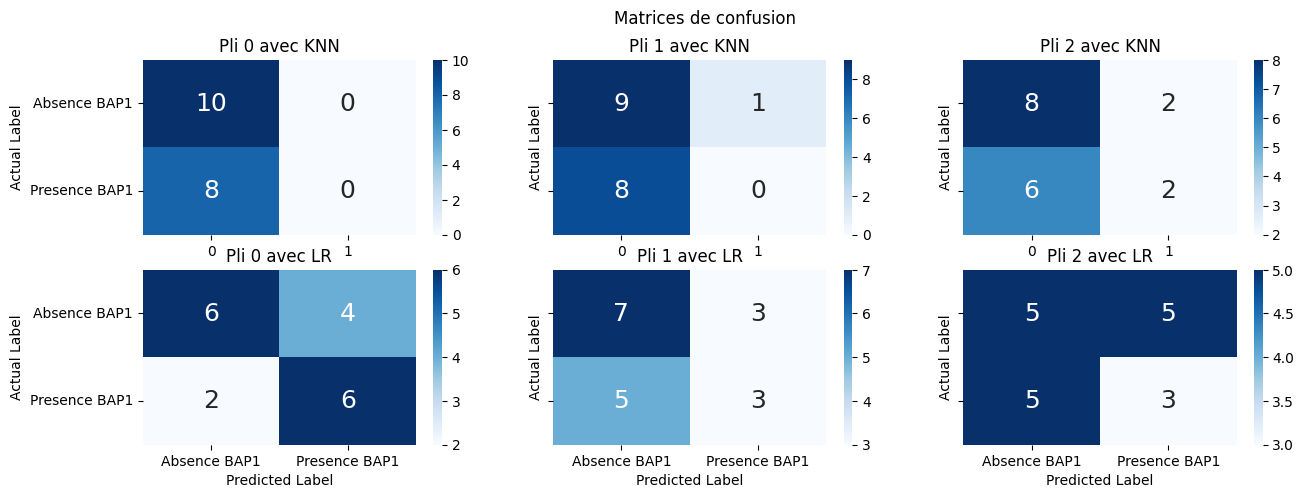

In [20]:
# Entrainement et test sur les 3 plis:

fig, axes = plt.subplots(2, 3, figsize=(15, 5), sharey=True)
fig.suptitle('Matrices de confusion')
classes=["Absence BAP1", "Presence BAP1"]

for i in range(3):
   mask_train = ~all['Slide'].isin(wsi_test[i])
   df_train = all[mask_train]
   df_train = df_train.drop(columns=['Slide','Coord_x','Coord_y'])
   X_train, y_train = df_train.drop(columns='BAP1_mutation'), df_train['BAP1_mutation']
   print(X_train.shape)

   knn_clf = KNeighborsClassifier(n_neighbors=15, metric='euclidean')
   knn_clf.fit(X_train, y_train)

   lr_clf = LogisticRegression(C=1/1024, penalty='l2', max_iter=1000, class_weight='balanced')
   lr_clf.fit(X_train, y_train)

   #svc_clf = SVC(kernel='poly', C=100)
   #svc_clf.fit(X_train, y_train)

   real_results=[]
   results_knn=[]
   results_lr=[]
   accuracy_knn=[]
   accuracy_lr=[]

   for wsi in wsi_test[i]:
      df_test = all[all['Slide']==wsi]
      df_test = df_test.drop(columns=['Slide','Coord_x','Coord_y'])
      X_test, y_test = df_test.drop(columns='BAP1_mutation'), df_test['BAP1_mutation']

      y_pred_knn = knn_clf.predict(X_test)
      y_pred_lr = lr_clf.predict(X_test)
      # y_pred_svc = svc_clf.predict(X_test)

      bap1_perc_knn = sum(i == 4 for i in y_pred_knn)/len(y_pred_knn)
      if bap1_perc_knn > 0.5:
         result_knn = 4
      else:
         result_knn = 0

      bap1_perc_lr = sum(i == 4 for i in y_pred_lr)/len(y_pred_lr)
      if bap1_perc_lr > 0.5:
         result_lr = 4
      else:
         result_lr = 0

      real_result=y_test.iloc[0]

      real_results.append(real_result)
      results_knn.append(result_knn)
      results_lr.append(result_lr)
      accuracy_knn.append(real_result==result_knn)
      accuracy_lr.append(real_result==result_lr)
   
   print("Pli",i,":")
   print('Accuracy knn :', sum(j==True for j in accuracy_knn)/len(wsi_test[i]))
   print('Accuracy LR :', sum(j==True for j in accuracy_lr)/len(wsi_test[i]))
   conf_matrix_knn = confusion_matrix(real_results,results_knn,labels=[0, 4])
   conf_matrix_lr = confusion_matrix(real_results,results_lr,labels=[0, 4])
   sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 18}, ax=axes[0,i], yticklabels = classes)
   sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 18}, ax=axes[1,i], xticklabels = classes, yticklabels = classes)
   axes[0,i].set_title('Pli '+str(i)+" avec KNN")
   axes[1,i].set_title('Pli '+str(i)+" avec LR")
   #axes[0,i].set_xlabel('Predicted Label')
   axes[1,i].set_xlabel('Predicted Label')
   axes[0,i].set_ylabel('Actual Label')
   axes[1,i].set_ylabel('Actual Label')

plt.show()

## Détection d'anomalies

In [12]:
# Création des 3 jeux de tests pour les 3 plis

# Pourcentage pour le test
perc_wsi_test = 0.3

all_wsi_bap1 = list(meta_slide.loc[meta_slide["BAP1_mutation"]==4]["Slide"])
all_wsi_no_bap1 = list(meta_slide.loc[meta_slide["BAP1_mutation"]==0]["Slide"])

n_wsi_test_bap1 = round(perc_wsi_test*len(all_wsi_bap1))
n_wsi_test_no_bap1 = round(perc_wsi_test*len(all_wsi_no_bap1))

# Si l'on souhaite utiliser que les tuiles classifiées comme interessantes
# all=all_cluster[all_cluster['Cluster']==0]

wsi_test_1=random.sample(all_wsi_bap1,n_wsi_test_bap1)+random.sample(all_wsi_no_bap1,n_wsi_test_no_bap1)
wsi_test_2=random.sample(all_wsi_bap1,n_wsi_test_bap1)+random.sample(all_wsi_no_bap1,n_wsi_test_no_bap1)
wsi_test_3=random.sample(all_wsi_bap1,n_wsi_test_bap1)+random.sample(all_wsi_no_bap1,n_wsi_test_no_bap1)
wsi_test=[wsi_test_1,wsi_test_2,wsi_test_3]

                                                  Comp_1    Comp_2    Comp_3  \
ID                                                                             
00d6aff9-16fc-4e9b-9fd4-9f90762b411c.svs_3_18   0.667736  0.083993  1.765178   
00d6aff9-16fc-4e9b-9fd4-9f90762b411c.svs_3_27   1.915728 -0.795124  1.188978   
00d6aff9-16fc-4e9b-9fd4-9f90762b411c.svs_3_28   1.540248 -0.448638  1.351273   
00d6aff9-16fc-4e9b-9fd4-9f90762b411c.svs_3_29   1.063004 -0.482294  1.354864   
00d6aff9-16fc-4e9b-9fd4-9f90762b411c.svs_4_16   0.380872 -0.336451  2.128930   
...                                                  ...       ...       ...   
3ee88133-7cdf-486d-8cf6-f765e2780c13.svs_67_51 -0.118860 -0.305796  2.315354   
3ee88133-7cdf-486d-8cf6-f765e2780c13.svs_67_53  0.719503 -0.402885  2.324642   
3ee88133-7cdf-486d-8cf6-f765e2780c13.svs_67_54  0.257187 -0.001510  2.887448   
3ee88133-7cdf-486d-8cf6-f765e2780c13.svs_67_55  0.525190 -0.383981  2.390832   
3ee88133-7cdf-486d-8cf6-f765e2780c13.svs

Training: 100%|██████████| 10/10 [01:24<00:00,  8.42s/it]


Pli 0 :
Accuracy autoencoder : 0.5
                                                  Comp_1    Comp_2    Comp_3  \
ID                                                                             
00d6aff9-16fc-4e9b-9fd4-9f90762b411c.svs_3_18   0.667736  0.083993  1.765178   
00d6aff9-16fc-4e9b-9fd4-9f90762b411c.svs_3_27   1.915728 -0.795124  1.188978   
00d6aff9-16fc-4e9b-9fd4-9f90762b411c.svs_3_28   1.540248 -0.448638  1.351273   
00d6aff9-16fc-4e9b-9fd4-9f90762b411c.svs_3_29   1.063004 -0.482294  1.354864   
00d6aff9-16fc-4e9b-9fd4-9f90762b411c.svs_4_16   0.380872 -0.336451  2.128930   
...                                                  ...       ...       ...   
3ee88133-7cdf-486d-8cf6-f765e2780c13.svs_67_51 -0.118860 -0.305796  2.315354   
3ee88133-7cdf-486d-8cf6-f765e2780c13.svs_67_53  0.719503 -0.402885  2.324642   
3ee88133-7cdf-486d-8cf6-f765e2780c13.svs_67_54  0.257187 -0.001510  2.887448   
3ee88133-7cdf-486d-8cf6-f765e2780c13.svs_67_55  0.525190 -0.383981  2.390832   
3ee88

Training: 100%|██████████| 10/10 [01:22<00:00,  8.20s/it]


Pli 1 :
Accuracy autoencoder : 0.5
                                                  Comp_1    Comp_2    Comp_3  \
ID                                                                             
00dbd8f5-a676-4efe-bde2-8ffc5367b582.svs_1_79  -0.906309 -1.029782 -0.820269   
00dbd8f5-a676-4efe-bde2-8ffc5367b582.svs_2_0    0.464573  0.421983  0.751495   
00dbd8f5-a676-4efe-bde2-8ffc5367b582.svs_2_13   0.986099 -0.964730 -0.111193   
00dbd8f5-a676-4efe-bde2-8ffc5367b582.svs_3_9    0.289449 -0.731497  2.190138   
00dbd8f5-a676-4efe-bde2-8ffc5367b582.svs_3_10  -0.405821 -0.385712  2.040287   
...                                                  ...       ...       ...   
42e4bcbc-b9ab-48a5-8c2c-d9dcf2bb4aaf.svs_39_31  0.978035  0.414410  2.129807   
42e4bcbc-b9ab-48a5-8c2c-d9dcf2bb4aaf.svs_39_32  1.146578 -0.141733  2.253547   
42e4bcbc-b9ab-48a5-8c2c-d9dcf2bb4aaf.svs_39_34  0.347520  0.060349  1.762525   
42e4bcbc-b9ab-48a5-8c2c-d9dcf2bb4aaf.svs_39_35  0.998174  0.054558  2.158556   
42e4b

Training: 100%|██████████| 10/10 [01:30<00:00,  9.05s/it]


Pli 2 :
Accuracy autoencoder : 0.3888888888888889


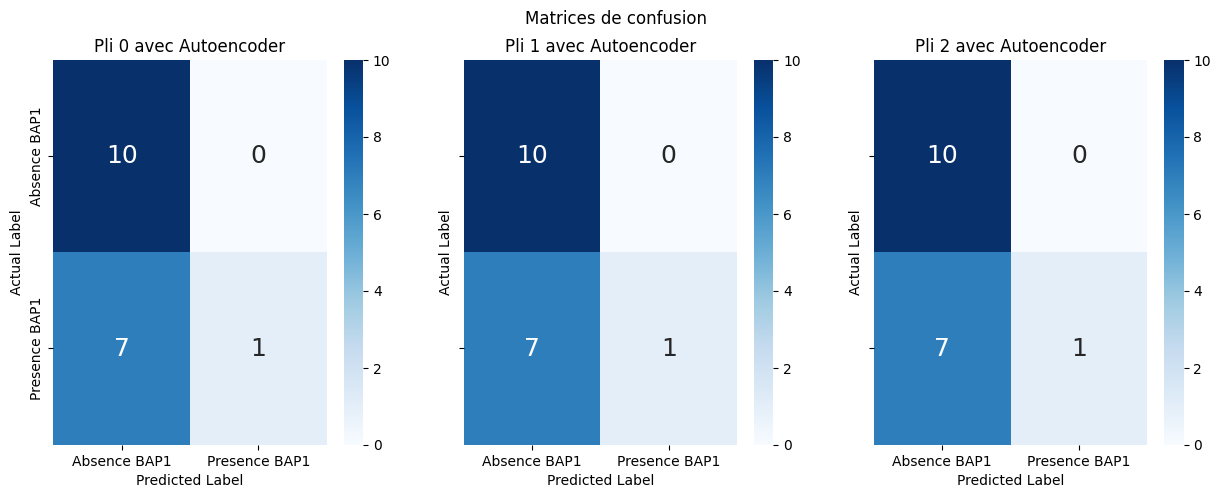

In [ ]:
# Entrainement et test sur les 3 plis:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('Matrices de confusion')
classes=["Absence BAP1", "Presence BAP1"]

for i in range(3):
   mask_train = ~all['Slide'].isin(wsi_test[i])
   df_train = all[mask_train]
   df_train = df_train.loc[df_train["BAP1_mutation"]==4]
   df_train = df_train.drop(columns=['Slide','Coord_x','Coord_y'])
   X_train = df_train.drop(columns='BAP1_mutation')
   #print(X_train)

   #clf = svm.OneClassSVM(kernel="rbf",nu=0.3)
   #clf.fit(X_train)

   model = AutoEncoder(contamination=0.3)
   model.fit(X_train)

   real_results=[]
   results_svm=[]
   results_autoencoder=[]
   accuracy_svm=[]
   accuracy_autoencoder=[]

   for wsi in wsi_test[i]:
      df_test = all[all['Slide']==wsi]
      df_test = df_test.drop(columns=['Slide','Coord_x','Coord_y'])
      X_test, y_test = df_test.drop(columns='BAP1_mutation'), df_test['BAP1_mutation']

      # y_pred_svm = clf.predict(X_test)
      y_pred_autoencoder = model.predict(X_test)

      # bap1_perc_svm = sum(i == 1 for i in y_pred_svm)/len(y_pred_svm)
      # if bap1_perc_svm > 0.5:
      #    result_svm = 4
      # else:
      #    result_svm = 0

      bap1_perc_autoencoder = sum(i == 0 for i in y_pred_autoencoder)/len(y_pred_autoencoder)
      if bap1_perc_autoencoder > 0.5:
         result_autoencoder = 4
      else:
         result_autoencoder = 0

      real_result=y_test.iloc[0]

      real_results.append(real_result)
      # results_svm.append(result_svm)
      results_autoencoder.append(result_autoencoder)
      # accuracy_svm.append(real_result==result_knn)
      accuracy_autoencoder.append(real_result==result_autoencoder)
   
   print("Pli",i,":")
   # print('Accuracy svm :', sum(j==True for j in accuracy_knn)/len(wsi_test[i]))
   print('Accuracy autoencoder :', sum(j==True for j in accuracy_autoencoder)/len(wsi_test[i]))
   # print(confusion_matrix(real_results,results_svm))
   conf_matrix_autoencoder = confusion_matrix(real_results,results_knn,labels=[0, 4])
   sns.heatmap(conf_matrix_autoencoder, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 18}, ax=axes[i], xticklabels = classes, yticklabels = classes)
   axes[i].set_title('Pli '+str(i)+" avec Autoencoder")
   axes[i].set_xlabel('Predicted Label')
   axes[i].set_ylabel('Actual Label')